<a href="https://colab.research.google.com/github/jeffheaton/app_deep_learning/blob/main/t81_558_class_09_3_reality_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# T81-558: Applications of Deep Neural Networks

**Module 9: Facial Recognition**

- Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
- For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).


# Module 9 Material

- Part 9.1: Detecting Faces in an Image [[Video]](https://www.youtube.com/watch?v=Hpp3D3P2iWQ&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_1_faces.ipynb)
- Part 9.2: Detecting Facial Features [[Video]](https://www.youtube.com/watch?v=AblTbq0T2wE&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_2_face_features.ipynb)
- **Part 9.3: Reality Augmentation** [[Video]](https://www.youtube.com/watch?v=jfZDiRxx5Bc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_3_reality_augmentation.ipynb)
- Part 9.4: Application: Emotion Detection [[Video]](https://www.youtube.com/watch?v=F0H6vojQhE8&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_4_emotion.ipynb)
- Part 9.5: Application: Blink Efficiency [[Video]](https://www.youtube.com/watch?v=96LPEStHCUA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_5_blink.ipynb)


# Google CoLab Instructions

The following code checks that Google CoLab is and sets up the correct hardware settings for PyTorch.


In [ ]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch

device = (
    "mps"
    if getattr(torch, "has_mps", False)
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}")


if device!='cuda':
  print("*******WARNING, this notebook requires a CUDA GPU****")
  print("This notebook will not work correctly!")

Note: using Google CoLab
Using device: cuda


# Part 9.3: Reality Augmentation


Facial landmarks in computer vision refer to a set of key points on human faces, which are commonly used to deduce the structure and features of the face. These landmarks can be found around regions such as the eyes, nose, mouth, and jawline, serving as anchor points for various image processing tasks. Leveraging these facial landmarks, we can augment images by overlaying additional elements or graphics on the face. For instance, to create a Python program that draws eyeglasses on people, we would first detect the facial landmarks, particularly focusing on those around the eyes. Once these points are identified, we can determine the size, orientation, and position where the eyeglasses should be placed. Using libraries such as OpenCV, facenet and SPIGA, the program can then overlay a graphic of eyeglasses onto the original image in a manner that looks natural, effectively "placing" the eyeglasses on the person's face.

We begin by installing SPIGA and Facenet.

In [ ]:
# Setup SPIGA and facenet
!pip install facenet-pytorch
!git clone https://github.com/andresprados/SPIGA.git
%cd SPIGA/
!pip install -e .

fatal: destination path 'SPIGA' already exists and is not an empty directory.
/content/SPIGA
Obtaining file:///content/SPIGA
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for spiga (pyproject.toml) ... done
  Created wheel for spiga: filename=spiga-0.0.6-0.editable-py3-none-any.whl size=7961 sha256=a46d82b6604f3e4de36b2377ea2e6cb9bc06f3f60f87c59fa85bbfcbc725d205
  Stored in directory: /tmp/pip-ephem-wheel-cache-her53_qp/wheels/51/78/17/4d636d7d4147e7d7a403fcd06d77681c57262817b7ae678952
Successfully built spiga
  Attempting uninstall: spiga
    Found existing installation: spiga 0.0.6
    Uninstalling spiga-0.0.6:
      Successfully uninstalled spiga-0.0.6


We are now ready to load an image to augment. The image is loaded as both a PIL and OpenCV form object. This duality is necessary because Facenet uses PIL format images; wehreas SPIGA uses OpenCV.

In [ ]:
import requests
import cv2
import numpy as np
from PIL import Image, ImageDraw
from facenet_pytorch import MTCNN

#url = "https://data.heatonresearch.com/images/wustl/data/img1-512.jpg"
url = "https://s3.amazonaws.com/data.heatonresearch.com/images/jeff/about-jeff-heaton-2020.jpg"

# Download the image using requests
response = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
response.raise_for_status()

# Convert the downloaded bytes to a numpy array
image = np.asarray(bytearray(response.content), dtype="uint8")

# Decode the numpy array to an OpenCV image
img = cv2.imdecode(image, cv2.IMREAD_COLOR)

# Convert the OpenCV image (NumPy array) to a PIL Image
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

mtcnn = MTCNN(keep_all=False, device=device)

# Detect faces
boxes, _ = mtcnn.detect(image_pil)

Once we've extracted a face we use SPIGA to determine the facial features.

In [ ]:
from spiga.inference.config import ModelConfig
from spiga.inference.framework import SPIGAFramework

# Create a bounding box for the face we just detected.
bbox = [
    boxes[0][0],
    boxes[0][1],
    boxes[0][2],
    boxes[0][3]]

# Process image
dataset = 'wflw'
processor = SPIGAFramework(ModelConfig(dataset))
features = processor.inference(img, [bbox])

SPIGA model loaded!


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


The provided code aims to overlay an eyeglasses graphic on top of an image of a face. The code starts by importing necessary modules. The image is duplicated using the **copy.deepcopy** method to create a canvas. This canvas will be modified to overlay the eyeglasses. The face's landmark points and headpose data are extracted from the features dictionary. These landmarks are crucial as they indicate key points on the face, such as the eyes, nose, and mouth.

The **draw_lens** function is defined to illustrate the lens of the eyeglasses. This function uses the OpenCV library (cv2) to draw an elliptical shape representing a lens. The function is called twice: once for the left lens and once for the right lens, using specific landmarks for placement and size.

A line is also drawn between the lenses, representing the bridge of the glasses. Finally, the canvas (image with the glasses overlay) is resized for a consistent width of 512 pixels while maintaining the original aspect ratio. The result is displayed using cv2_imshow, which is tailored for viewing images within Google Colab notebooks.

[779.71813149 542.34149465]
[1042.78826745  542.1190184 ]


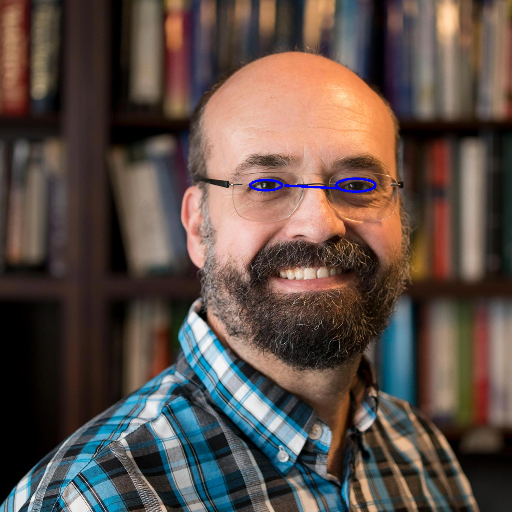

In [ ]:
import copy
from spiga.demo.visualize.plotter import Plotter
from google.colab.patches import cv2_imshow

# Prepare variables


canvas = copy.deepcopy(img)
landmarks = np.array(features['landmarks'][0])
headpose = np.array(features['headpose'][0])

# Show image results

def draw_lens(canvas,center,top,side):
  print(center)
  l1 = int(cv2.norm(center.astype(int),top.astype(int)))
  l2 = int(cv2.norm(center.astype(int),side.astype(int)))
  cv2.ellipse(canvas, center.astype(int), (l1,l2),
            0, 0, 360, (255,0,0), 5)

draw_lens(canvas,landmarks[96],landmarks[60],landmarks[62])
draw_lens(canvas,landmarks[97],landmarks[68],landmarks[70])
cv2.line(canvas,landmarks[68].astype(int),landmarks[64].astype(int),(255,0,0),5)


(h, w) = canvas.shape[:2]
canvas = cv2.resize(canvas, (512, int(h*512/w)))
cv2_imshow(canvas)